In [1]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.7MB 5.8MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train, test = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [9]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [10]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [11]:
# Normalize the data
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    # divide all by 255 to normalize from 0-1
    images /= 255
    return images, labels

# map the normalize function to the train and test sets
train = train.map(normalize)
test = test.map(normalize)

# cache the datset to keep in memory (faster training)
train = train.cache()
test = test.cache()

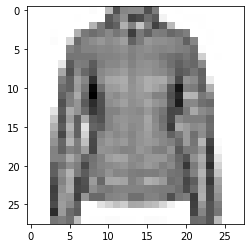

In [15]:
# plot images

# as it happens, img and lab exist in the global scope
for img, lab in test.take(1):
    break


img = img.numpy().reshape((28, 28))

plt.figure()
plt.imshow(img, cmap=plt.cm.binary)
plt.colorbar
plt.grid(False)
plt.show()

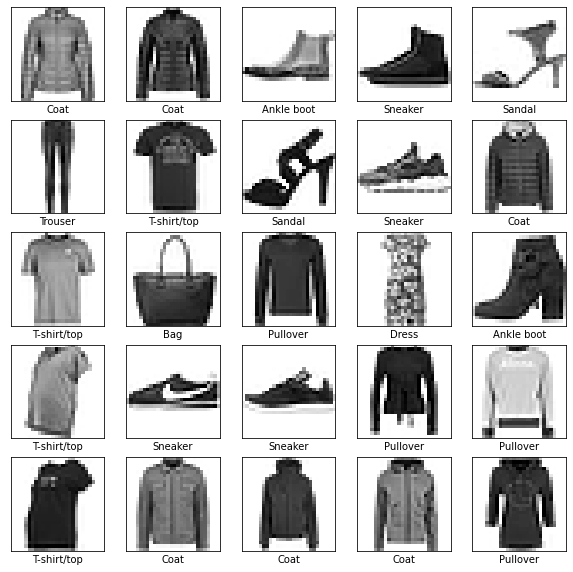

In [26]:
plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(test.take(25)):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])

plt.show()

### Building the model

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)                             
])

### Compiling

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train

In [29]:
BATCH_SIZE = 32
# shuffle the 60,000 examples and repeat indefinitely (what I'm not sure)
train = train.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test = test.cache().batch(BATCH_SIZE)

In [30]:
model.fit(train, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 9s 2ms/step - loss: 0.6415 - accuracy: 0.7744
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3919 - accuracy: 0.8606
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3447 - accuracy: 0.8745
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3156 - accuracy: 0.8856
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3005 - accuracy: 0.8909


### Accuracy eval


In [32]:
test_loss, test_accuracy = model.evaluate(test, steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.3525 - accuracy: 0.8729
Test Accuracy: 0.8729000091552734


### Making Predictions

In [34]:
for test_images, test_labels in test.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [35]:
predictions.shape

(32, 10)

In [38]:
predictions[0]

array([2.4934965e-05, 1.2581263e-06, 1.3309713e-02, 7.3067868e-06,
       9.5641947e-01, 5.7785970e-11, 3.0193245e-02, 3.8886161e-09,
       4.4023011e-05, 6.9488842e-10], dtype=float32)

In [39]:
np.argmax(predictions[0])

4

In [40]:
test_labels[0]

4

In [43]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

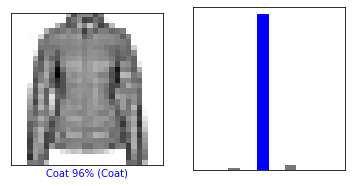

In [44]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

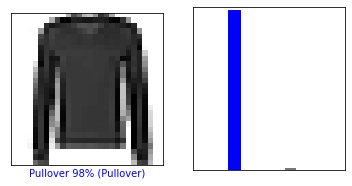

In [45]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

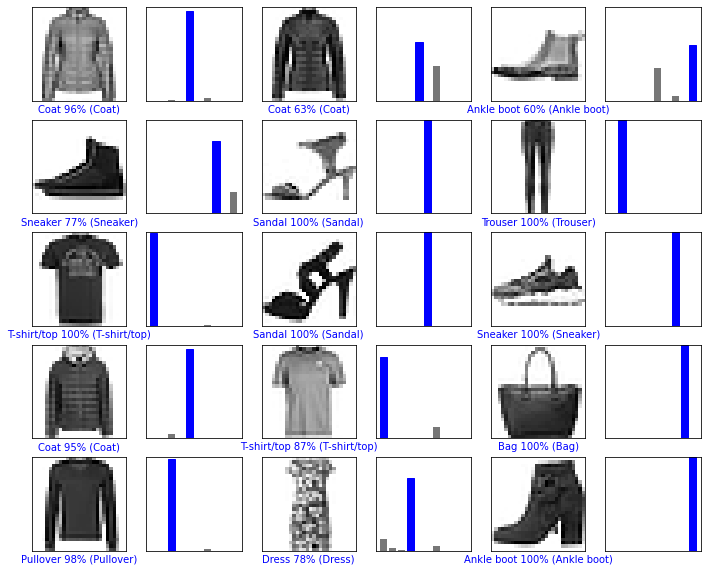

In [46]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [49]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [52]:
img = np.array([img])

single_pred = model.predict(img)
print(single_pred)

[[2.4934965e-05 1.2581287e-06 1.3309719e-02 7.3068004e-06 9.5641947e-01
  5.7785970e-11 3.0193275e-02 3.8886085e-09 4.4023051e-05 6.9488837e-10]]


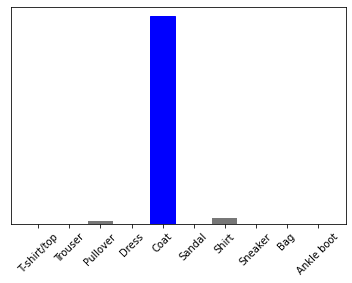

In [54]:
plot_value_array(0, single_pred, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [55]:
np.argmax(single_pred[0])

4